In [2]:
!pip -q install datasets transformers accelerate torch scikit-learn wandb evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.3 MB/s eta 0:00:00


In [3]:
from google.colab import userdata
HF_TOKEN = userdata.get('HF_TOKEN')

In [4]:
from huggingface_hub import notebook_login, login
login(HF_TOKEN, add_to_git_credential=True)

Token is valid (permission: write).
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [5]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [6]:
wandb.init(project="vit-for-trash")

wandb: Currently logged in as: seputargame3576 (xgame). Use `wandb login --relogin` to force relogin


In [7]:
%env WANDB_LOG_MODEL=checkpoint

env: WANDB_LOG_MODEL=checkpoint


In [8]:
from datasets import load_dataset, DatasetDict
loaded_dataset = load_dataset("garythung/trashnet")

README.md:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

dataset-original.zip:   0%|          | 0.00/3.63G [00:00<?, ?B/s]

dataset-resized.zip:   0%|          | 0.00/42.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5054 [00:00<?, ? examples/s]

In [9]:
train_test = loaded_dataset["train"].train_test_split(test_size=0.3, stratify_by_column="label")
val_test = train_test["test"].train_test_split(test_size=0.5, stratify_by_column="label")

In [10]:
dataset = DatasetDict({
    "train" : train_test["train"],
    "validation" : val_test["train"],
    "test" : val_test["test"]

})

In [11]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 3537
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 758
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 759
    })
})

In [12]:
train_ds = dataset["train"]
val_ds = dataset["validation"]
test_ds = dataset["test"]

In [13]:
id2label = {id: label for id, label in enumerate(train_ds.features["label"].names)}
label2id = {label: id for id, label in id2label.items()}
id2label, id2label[train_ds[0]["label"]]

({0: 'cardboard',
  1: 'glass',
  2: 'metal',
  3: 'paper',
  4: 'plastic',
  5: 'trash'},
 'glass')

In [14]:
from transformers import ViTImageProcessor

model_name = "google/vit-large-patch16-224"
processor = ViTImageProcessor.from_pretrained(model_name)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [23]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomVerticalFlip,
    RandomResizedCrop,
    ToTensor,
    Resize,
)

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)

train_transforms = Compose(
    [
        RandomResizedCrop(size),
        RandomHorizontalFlip(),
        RandomVerticalFlip(),
        ToTensor(),
        normalize,
    ]
)
val_transforms = Compose(
    [
        Resize(size),
        CenterCrop(size),
        ToTensor(),
        normalize,
    ]
)
test_transforms = Compose(
    [
        Resize(size),
        ToTensor(),
        normalize,
    ]
)

In [24]:
def apply_train_transforms(examples):
    examples["pixel_values"] = [train_transforms(image.convert("RGB")) for image in examples["image"]]
    return examples


def apply_val_transforms(examples):
    examples["pixel_values"] = [val_transforms(image.convert("RGB")) for image in examples["image"]]
    return examples


def apply_test_transforms(examples):
    examples["pixel_values"] = [val_transforms(image.convert("RGB")) for image in examples["image"]]
    return examples

In [25]:
train_ds.set_transform(apply_train_transforms)
val_ds.set_transform(apply_val_transforms)
test_ds.set_transform(apply_test_transforms)

In [26]:
import torch
from torch.utils.data import DataLoader


def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}


train_dl = DataLoader(train_ds, collate_fn=collate_fn, batch_size=4)

In [28]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained(
    model_name, id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-large-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([6, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
import numpy as np
from evaluate import load

metric = load("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)


In [30]:
from transformers import TrainingArguments, Trainer
import numpy as np

train_args = TrainingArguments(
    output_dir="output-models",
    save_total_limit=2,
    report_to="wandb",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=15,
    per_device_eval_batch_size=10,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_dir="logs",
    remove_unused_columns=False,
    run_name = 'second-run'
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [31]:
trainer = Trainer(
    model,
    train_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    tokenizer=processor,
    compute_metrics=compute_metrics,

)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.139461,0.955145
2,No log,0.075966,0.978892
3,0.243200,0.053977,0.981530


wandb: Adding directory to artifact (./output-models/checkpoint-236)... Done. 45.8s
wandb: Adding directory to artifact (./output-models/checkpoint-472)... Done. 58.0s
wandb: Adding directory to artifact (./output-models/checkpoint-708)... Done. 44.6s
wandb: Adding directory to artifact (./output-models/checkpoint-708)... Done. 43.9s


TrainOutput(global_step=708, training_loss=0.18756323884435966, metrics={'train_runtime': 3813.2698, 'train_samples_per_second': 2.783, 'train_steps_per_second': 0.186, 'total_flos': 2.9067548749571727e+18, 'train_loss': 0.18756323884435966, 'epoch': 3.0})

In [32]:
outputs = trainer.predict(test_ds)
print(outputs.metrics)

{'test_loss': 0.05395105853676796, 'test_accuracy': 0.9881422924901185, 'test_runtime': 171.7816, 'test_samples_per_second': 4.418, 'test_steps_per_second': 0.442}


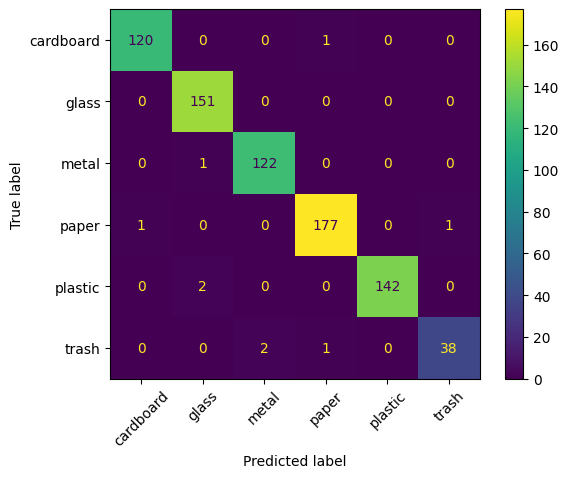

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_ds.features["label"].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

In [34]:
from sklearn.metrics import recall_score

# Calculate the recall scores
# 'None' calculates recall for each class separately
recall = recall_score(y_true, y_pred, average=None)

# Print the recall for each class
for label, score in zip(labels, recall):
    print(f"Recall for {label}: {score:.2f}")

Recall for cardboard: 0.99
Recall for glass: 1.00
Recall for metal: 0.99
Recall for paper: 0.99
Recall for plastic: 0.99
Recall for trash: 0.93


In [35]:
from sklearn.metrics import precision_score

# Calculate the precision scores
# 'None' calculates precision for each class separately
precision = precision_score(y_true, y_pred, average=None)

# Print the precision for each class
for label, score in zip(labels, precision):
    print(f"precision for {label}: {score:.2f}")

precision for cardboard: 0.99
precision for glass: 0.98
precision for metal: 0.98
precision for paper: 0.99
precision for plastic: 1.00
precision for trash: 0.97


In [36]:
from sklearn.metrics import accuracy_score

# Calculate the accuracy scores
# 'None' calculates accuracy for each class separately
accuracy = accuracy_score(y_true, y_pred)

print("Accuracy:", accuracy)

Accuracy: 0.9881422924901185


In [37]:
model.push_to_hub("trash-classification-vit")

README.md:   0%|          | 0.00/1.32k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.21G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/suramadu08/trash-classification-vit/commit/17b85735f51fe3e0a7f99afbd46e7e4a371e10d1', commit_message='Upload ViTForImageClassification', commit_description='', oid='17b85735f51fe3e0a7f99afbd46e7e4a371e10d1', pr_url=None, pr_revision=None, pr_num=None)

In [38]:
wandb.finish()

eval/accuracy,▁▇█
eval/loss,█▃▁
eval/runtime,▁▁█
eval/samples_per_second,██▁
eval/steps_per_second,██▁
test/accuracy,▁
test/loss,▁
test/runtime,▁
test/samples_per_second,▁
test/steps_per_second,▁
train/epoch,▁▅▅██
